In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from sklearn.preprocessing import normalize

import utils.metrics as metrics
import preprocessing.extra_points_removing as epr
import preprocessing.data_loading as data_loading

In [2]:
df = data_loading.load_train_dataframe()
df_test = data_loading.load_test_dataframe()

In [3]:
df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds,delta_time
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000,2803.000
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2803.000,2803.000
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,5606.001,2803.001
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,8409.001,2803.000
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,11212.002,2803.001


Описание полей датасета:
- id - integer measurement id
- epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
- sat_id — integer satellite id
- (x, y, z), (x_sim, y_sim, z_sim)	реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) координаты спутника (км)
- реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) скорости спутника (км / с)

In [4]:
real_columns = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
sim_columns = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']

In [5]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

print(metrics.smape(satellite_predicted_values, satellite_true_values))
print(metrics.score(satellite_predicted_values, satellite_true_values))

0.15973600741329672
84.02639925867032


## Сопоставление данных из тестовой и обучающей выборок для одного спутника

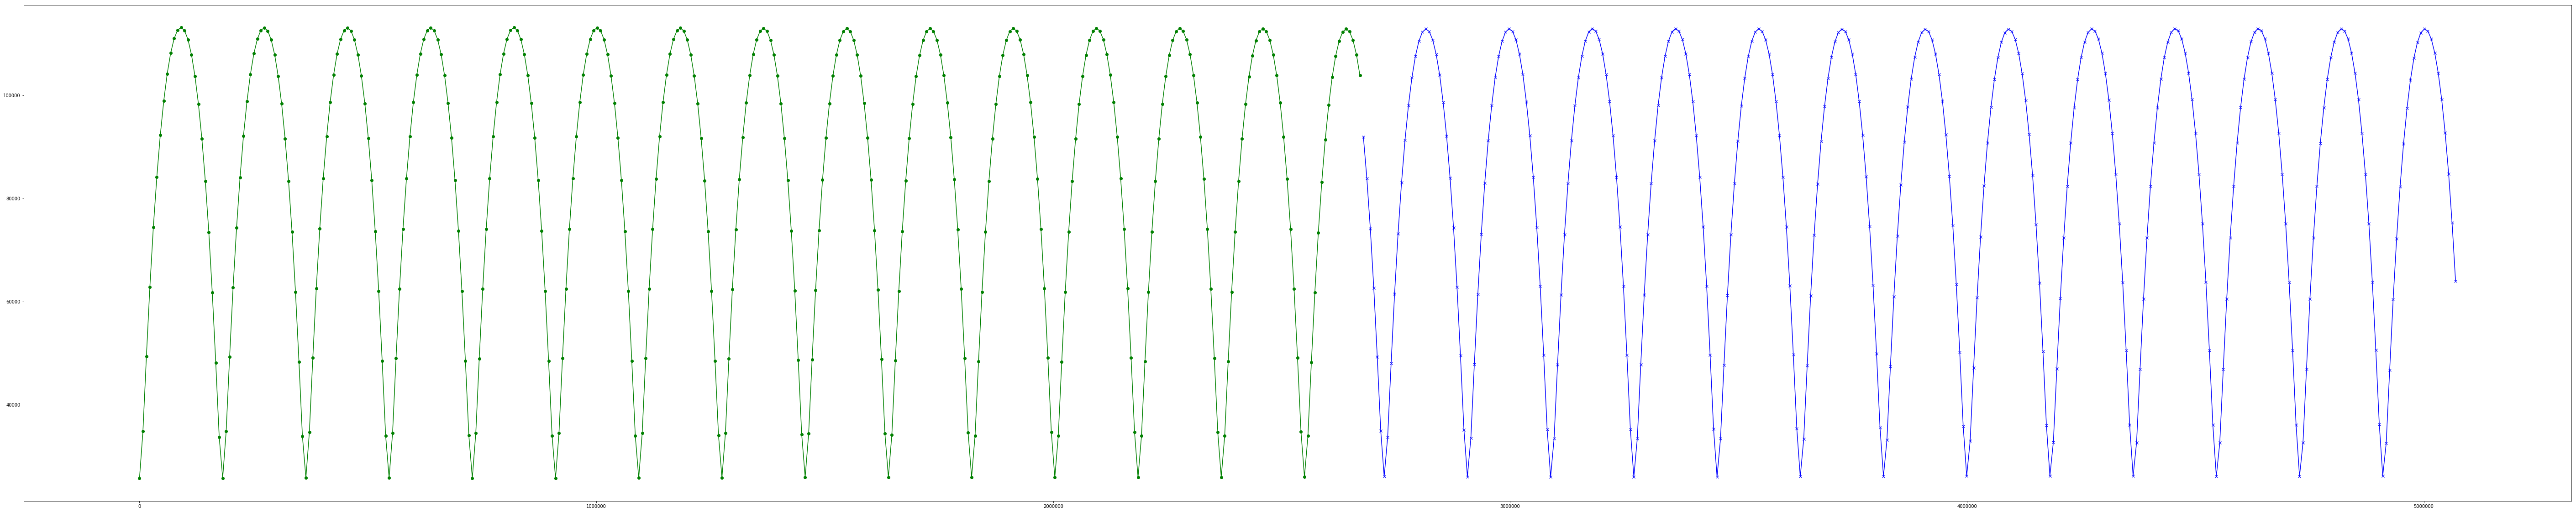

In [6]:
index = 3

plt.figure(figsize = (100, 20))
sat = df[df.sat_id==index]

x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-go')

sat = df_test[df_test.sat_id==index]
x = sat['total_seconds']

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'-bx')

plt.show()

## Визуализация роста ошибки с течением времени

In [7]:
satellite_true_values = df[real_columns].to_numpy()
satellite_predicted_values = df[sim_columns].to_numpy()

df['error'] = np.mean(np.abs((satellite_predicted_values - satellite_true_values)
                                / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))), axis=1)

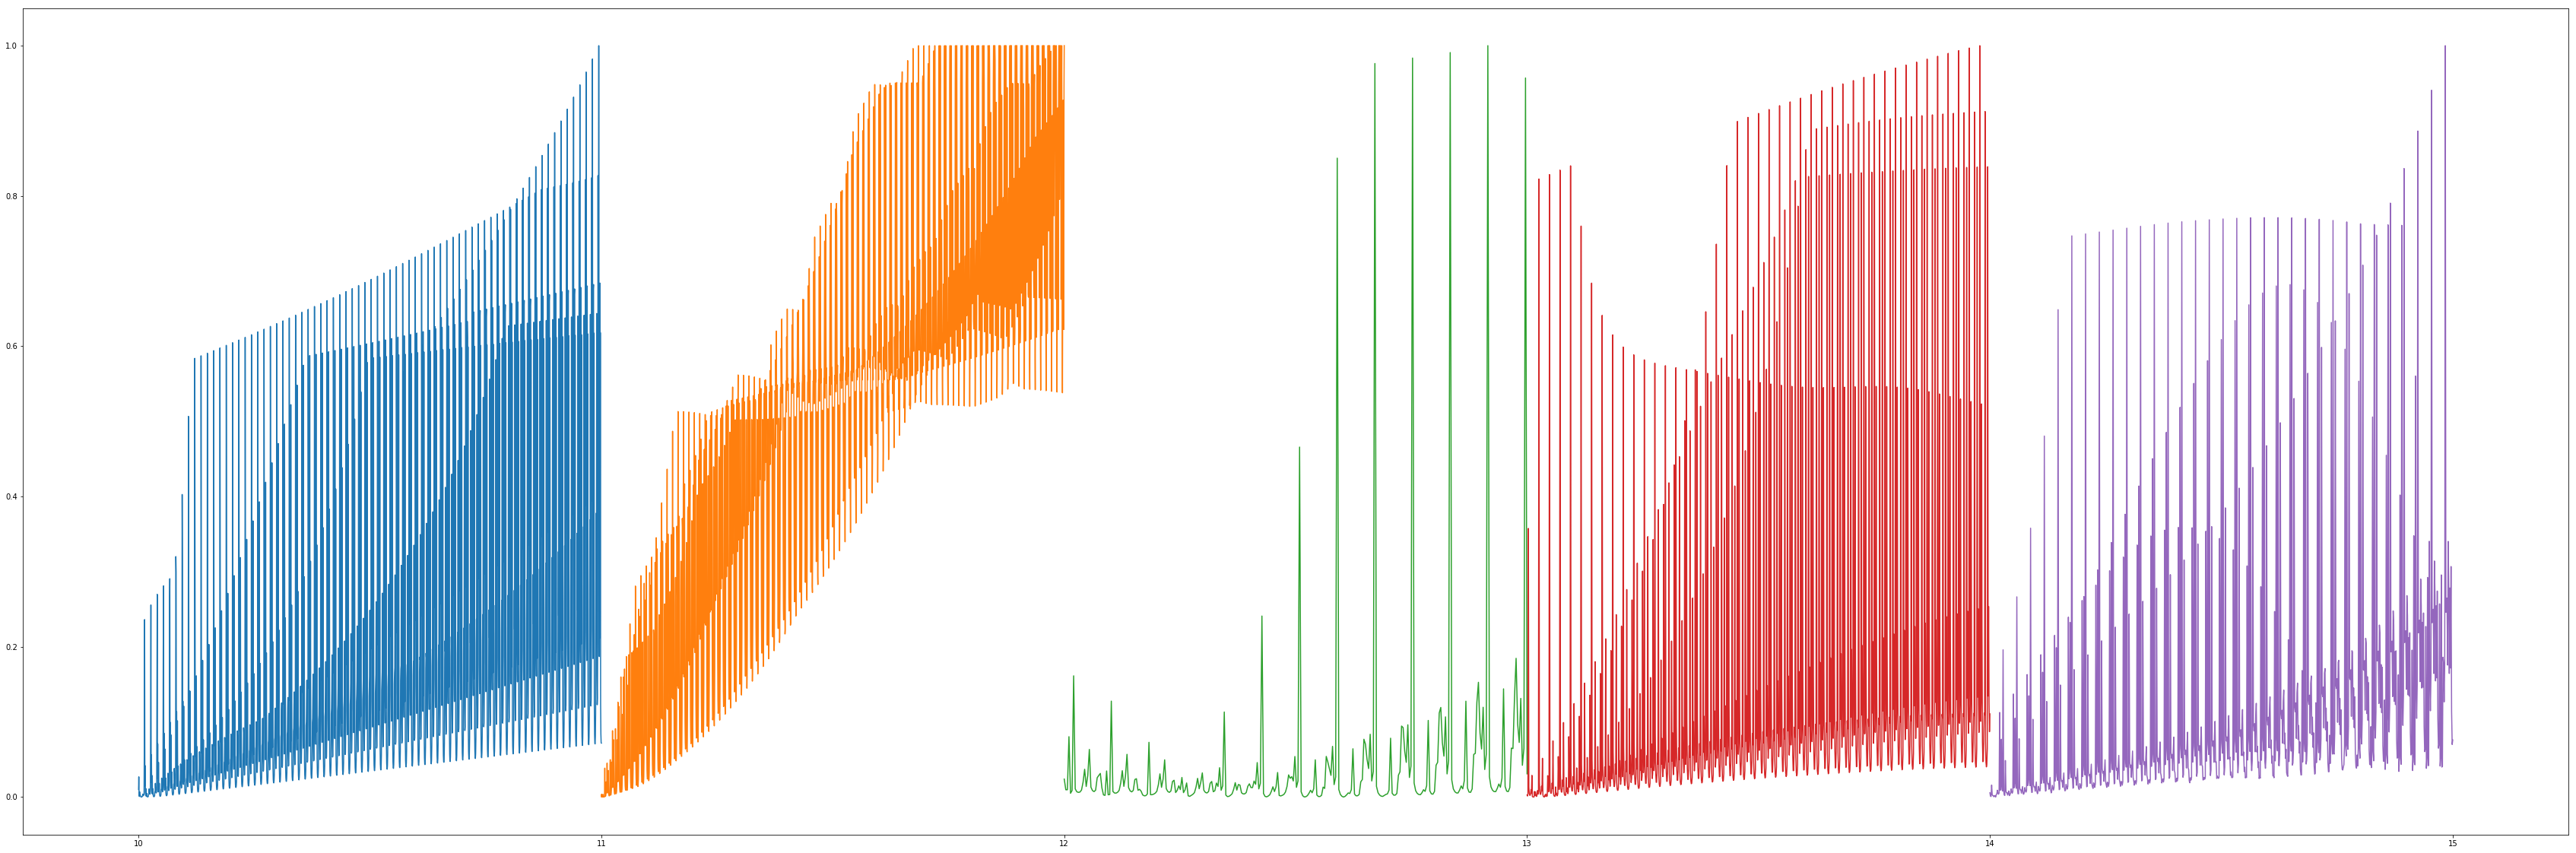

In [8]:
plt.figure(figsize = (60, 20))

for i in range(10,15):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    y=y-y.min()
    y=y/y.max()
    plt.plot(x,y)
    
plt.show()

## Сопоставление высоты полета спутника и  ошибки

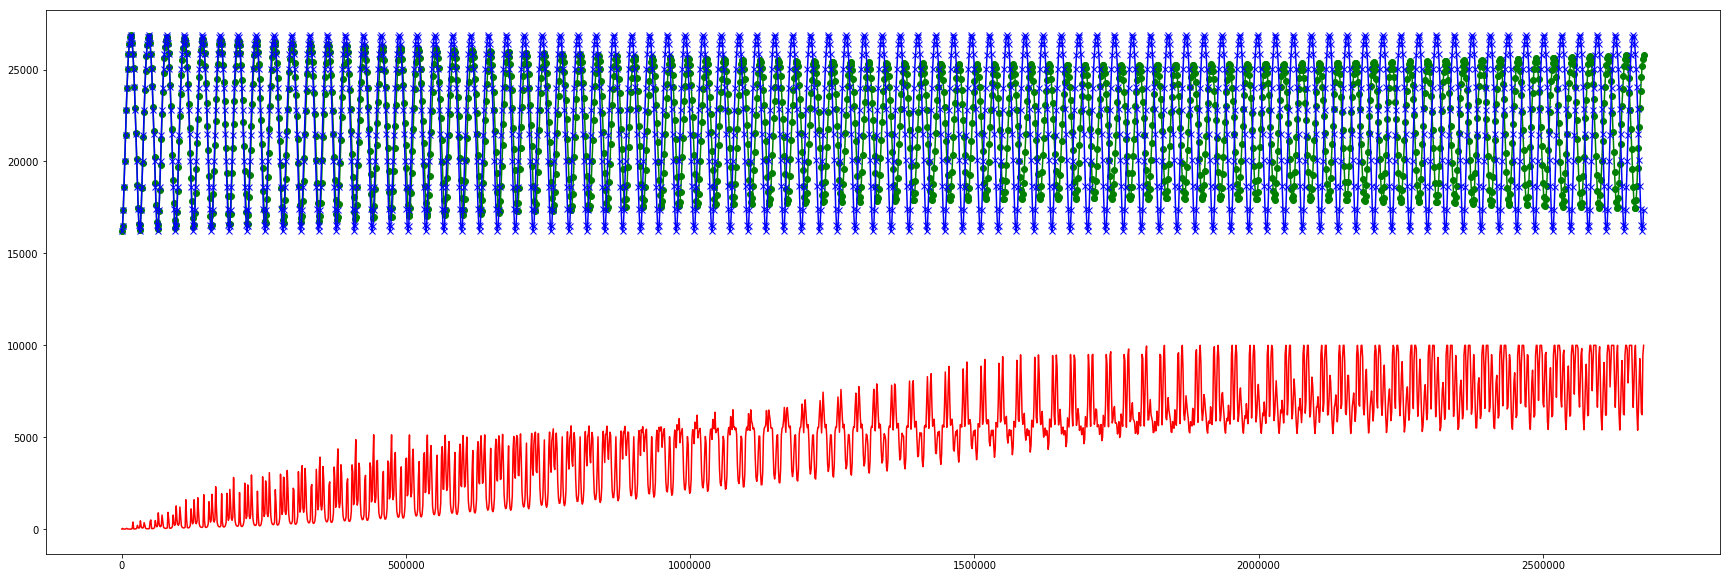

16198.432364793938


In [9]:
plt.figure(figsize = (30, 10))
sat = df[df.sat_id==11]

#x = np.linspace(0.0, 1.0, num=len(sat))
x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

#x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['error']*10000, '-r')

plt.show()
print(y.min())

## Случайно наткнулся на линейную зависимость между средней высотой полета спутника и разбросом его высот, скорее всего это бесполезно для нашей задачи, но я все же хочу изучить этот момент позже

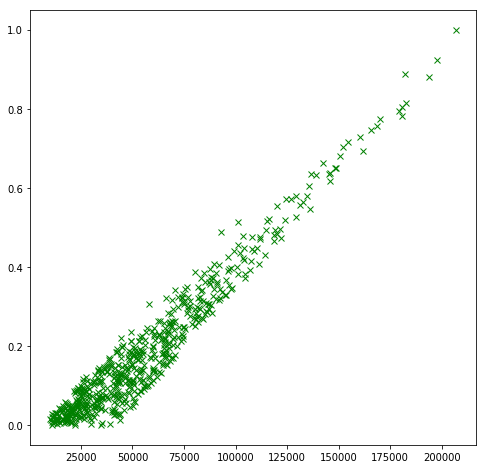

In [10]:
df['h'] = (df.x**2 + df.y**2 + df.z**2)**0.5

h_list = []
y_delta = []

for i in df['sat_id'].unique():
    sat = df[df['sat_id']==i]
    
    h_list.append(np.mean(sat['h']))
    y_delta.append(max(sat.h)-min(sat.h))

plt.figure(figsize = (8, 8))

y_delta = np.array(y_delta)
y_delta=y_delta-y_delta.min()
y_delta=y_delta/y_delta.max()

plt.plot(h_list,y_delta, 'gx')
    
plt.show()

## Расчет траектории спутника и её визуализация

In [11]:
from astropy import units as u
from astropy.time import Time

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [12]:
op = OrbitPlotter3D()

for i in range(10):
    
    sat = df[df.sat_id==i]
    x=list(sat.x)
    y=list(sat.y)
    z=list(sat.z)

    Vx=list(sat.Vx)
    Vy=list(sat.Vy)
    Vz=list(sat.Vz)
    
    epoch=list(sat.epoch)

    r = [x[0], y[0], z[0]] * u.km
    v = [Vx[0], Vy[0], Vz[0]] * u.km / u.s
    ss = Orbit.from_vectors(Earth, r, v, epoch=Time(datetime(2014, 1, 1)))

    op.plot(ss, label=str(i))
op.plot(ss, label=str(i))

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'dash', 'width': 5},
             …

In [14]:
op = OrbitPlotter3D()
    
sat = df[df.sat_id==20]
x=list(sat.x)
y=list(sat.y)
z=list(sat.z)

Vx=list(sat.Vx)
Vy=list(sat.Vy)
Vz=list(sat.Vz)

total_seconds = list(sat.total_seconds)


r = [x[0], y[0], z[0]] * u.km
v = [Vx[0], Vy[0], Vz[0]] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v, epoch=Time(datetime(2014, 1, 1)))

for i in range(23):
    ss_after = ss.propagate(total_seconds[i] * u.s)
    op.plot(ss_after, label=str(i))

op.plot(ss, label=str(i))

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'dash', 'width': 5},
             …